In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
for x in session.query(Measurement.date).filter(Measurement.date > dt.date(2010, 1, 3)).limit(5):
    print(str(x)[2:-3])

2010-01-04
2010-01-06
2010-01-07
2010-01-08
2010-01-09


date 1 week ago from today
week_ago = dt.date.today() - dt.timedelta(days=7)

In [28]:
type (session.query(Measurement.date))

sqlalchemy.orm.query.Query

In [20]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
yearAgo = dt.datetime.strftime(dt.date(2016, 11,1)-dt.timedelta(days=365), '%Y-%m-%d')
rain = session.query(Measurement).filter(Measurement.date > (yearAgo)).limit(365)
rain_list = []
for x in rain:
    rain_list.append(x.prcp)

In [21]:
x_axis = np.arange( 0, 365,1)
# x_axis

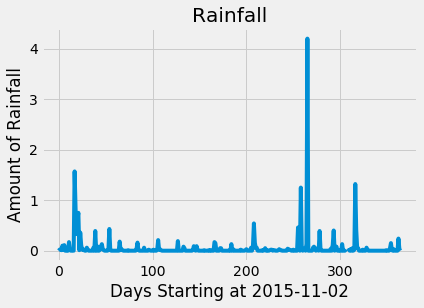

In [22]:
fig, ax = plt.subplots()
# ax.scatter(x_axis, rain_list, alpha = .4, edgecolors = 'black')
ax.plot(x_axis, rain_list)
# ax.bar(x_axis, rain_list)
plt.title("Rainfall")
plt.xlabel(f"Days Starting at {yearAgo}")
plt.ylabel("Amount of Rainfall")
# plt.savefig("rainfall.png")
# Show the Figure
plt.show()

In [14]:
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
dtLastDate = dt.datetime.strptime(last_date[0], '%Y-%m-%d')
last_year = dt.datetime.strftime(dtLastDate - dt.timedelta(weeks = 52), '%Y-%m-%d')
last_year

'2016-08-24'

In [15]:
# Perform a query to retrieve the data and precipitation scores
precip_info = session.query(Measurement).filter(Measurement.date > last_year)

In [16]:
# Save the query results as a Pandas DataFrame and set the index to the date column
date_list = []
precip_list = []
for i in precip_info:
    date_list.append(i.date)
    precip_list.append(i.prcp)
    
dfDict = {'date' : date_list,
         'prcp' : precip_list}

precipDF = pd.DataFrame.from_dict(dfDict)
precipDF.head()

,date,prcp
0,2016-08-25,0.08
1,2016-08-26,0.00
2,2016-08-27,0.00
3,2016-08-28,0.01
4,2016-08-29,0.00


I know this should become a different data frame, but that would change lots of other code.

In [17]:
precipDF = precipDF.dropna()

In [18]:
# Sort the dataframe by date
prcp_sort_df = precipDF.sort_values('date', axis=0)
prcp_sort_df.set_index('date')
prcp_sort_df.head()

,date,prcp
0,2016-08-25,0.08
1184,2016-08-25,0.21
1003,2016-08-25,0.00
700,2016-08-25,0.00
1869,2016-08-25,0.11


In [19]:
prcp_sort_df.count()

date    2009
prcp    2009
dtype: int64

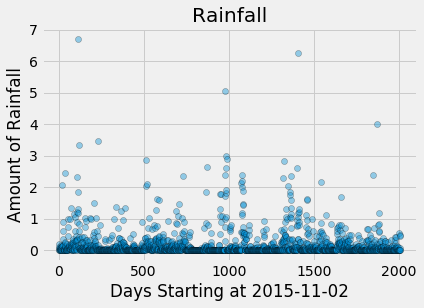

In [20]:
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots()
x_axis2 = np.arange(0,2009,1)
ax.scatter(x_axis2, prcp_sort_df.prcp, alpha = .4, edgecolors = 'black')
plt.title("Rainfall")
plt.xlabel(f"Days Starting at {yearAgo}")
plt.ylabel("Amount of Rainfall")
# plt.savefig("rainfall.png")
# Show the Figure
plt.show()

![precipitation](Images/precipitation.png)

In [21]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_sort_df.describe()

,prcp
count,2009.000000
mean,0.172344
std,0.452818
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [25]:
for x in session.query(Station):
    print(x.station)

USC00519397
USC00513117
USC00514830
USC00517948
USC00518838
USC00519523
USC00519281
USC00511918
USC00516128


In [29]:
# Design a query to show how many stations are available in this dataset?
session.query(Station).count()

9

In [45]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station))\
.group_by(Measurement.station).order_by(desc(func.count(Measurement.station))).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [47]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(Measurement.prcp), func.max(Measurement.prcp), func.avg(Measurement.prcp))\
.filter(Measurement.station == 'USC00519281').all()

[(0.0, 9.64, 0.2123520923520915)]

In [53]:
session.query(Measurement.station, func.count(Measurement.tobs))\
.group_by(Measurement.station).order_by(desc(func.count(Measurement.station))).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
quick_list = session.query(Measurement.tobs).filter(Measurement.station == "USC00519281").filter(Measurement.date > (yearAgo)).all()
quick_list

[(75.0),
 (77.0),
 (73.0),
 (73.0),
 (74.0),
 (79.0),
 (72.0),
 (76.0),
 (76.0),
 (72.0),
 (73.0),
 (73.0),
 (77.0),
 (71.0),
 (66.0),
 (67.0),
 (73.0),
 (71.0),
 (72.0),
 (78.0),
 (73.0),
 (70.0),
 (70.0),
 (75.0),
 (74.0),
 (76.0),
 (72.0),
 (75.0),
 (73.0),
 (74.0),
 (75.0),
 (75.0),
 (70.0),
 (72.0),
 (69.0),
 (68.0),
 (74.0),
 (72.0),
 (75.0),
 (79.0),
 (69.0),
 (67.0),
 (73.0),
 (74.0),
 (75.0),
 (72.0),
 (76.0),
 (74.0),
 (75.0),
 (74.0),
 (74.0),
 (76.0),
 (74.0),
 (75.0),
 (75.0),
 (73.0),
 (76.0),
 (74.0),
 (73.0),
 (74.0),
 (72.0),
 (68.0),
 (69.0),
 (70.0),
 (69.0),
 (76.0),
 (75.0),
 (74.0),
 (74.0),
 (73.0),
 (75.0),
 (74.0),
 (66.0),
 (71.0),
 (73.0),
 (75.0),
 (63.0),
 (61.0),
 (62.0),
 (65.0),
 (65.0),
 (75.0),
 (78.0),
 (69.0),
 (65.0),
 (69.0),
 (64.0),
 (68.0),
 (73.0),
 (74.0),
 (69.0),
 (68.0),
 (69.0),
 (65.0),
 (67.0),
 (69.0),
 (70.0),
 (56.0),
 (57.0),
 (58.0),
 (61.0),
 (71.0),
 (74.0),
 (71.0),
 (75.0),
 (72.0),
 (71.0),
 (72.0),
 (69.0),
 (71.0),
 (72.0),
 

In [36]:
quick_list2 = []
for x in quick_list:
    quick_list2.append(x[0])
quick_list2

[75.0,
 77.0,
 73.0,
 73.0,
 74.0,
 79.0,
 72.0,
 76.0,
 76.0,
 72.0,
 73.0,
 73.0,
 77.0,
 71.0,
 66.0,
 67.0,
 73.0,
 71.0,
 72.0,
 78.0,
 73.0,
 70.0,
 70.0,
 75.0,
 74.0,
 76.0,
 72.0,
 75.0,
 73.0,
 74.0,
 75.0,
 75.0,
 70.0,
 72.0,
 69.0,
 68.0,
 74.0,
 72.0,
 75.0,
 79.0,
 69.0,
 67.0,
 73.0,
 74.0,
 75.0,
 72.0,
 76.0,
 74.0,
 75.0,
 74.0,
 74.0,
 76.0,
 74.0,
 75.0,
 75.0,
 73.0,
 76.0,
 74.0,
 73.0,
 74.0,
 72.0,
 68.0,
 69.0,
 70.0,
 69.0,
 76.0,
 75.0,
 74.0,
 74.0,
 73.0,
 75.0,
 74.0,
 66.0,
 71.0,
 73.0,
 75.0,
 63.0,
 61.0,
 62.0,
 65.0,
 65.0,
 75.0,
 78.0,
 69.0,
 65.0,
 69.0,
 64.0,
 68.0,
 73.0,
 74.0,
 69.0,
 68.0,
 69.0,
 65.0,
 67.0,
 69.0,
 70.0,
 56.0,
 57.0,
 58.0,
 61.0,
 71.0,
 74.0,
 71.0,
 75.0,
 72.0,
 71.0,
 72.0,
 69.0,
 71.0,
 72.0,
 60.0,
 69.0,
 67.0,
 64.0,
 69.0,
 69.0,
 71.0,
 69.0,
 72.0,
 63.0,
 63.0,
 62.0,
 70.0,
 72.0,
 67.0,
 74.0,
 66.0,
 68.0,
 68.0,
 72.0,
 72.0,
 71.0,
 70.0,
 68.0,
 68.0,
 68.0,
 68.0,
 71.0,
 66.0,
 65.0,
 63.0,
 64.0,

In [37]:
temp_df = pd.DataFrame({'temp': quick_list2})
temp_df.head()

,temp
0,75.0
1,77.0
2,73.0
3,73.0
4,74.0


In [43]:
min_temp = session.query(func.min(Measurement.tobs)).all()[0][0]
max_temp = session.query(func.max(Measurement.tobs)).all()[0][0]
tempbins = np.arange(min_temp, max_temp, (max_temp-min_temp)/12)

In [44]:
temp_df.temp.head()

0    75.0
1    77.0
2    73.0
3    73.0
4    74.0
Name: temp, dtype: float64

In [51]:
temp_df['bins'] = pd.cut(temp_df.temp, 12, labels = False)
group_count = temp_df.groupby('bins').count()
group_count

,temp
bins,
0,3
1,6
2,12
3,31
4,34
5,67
6,68
7,166
8,125


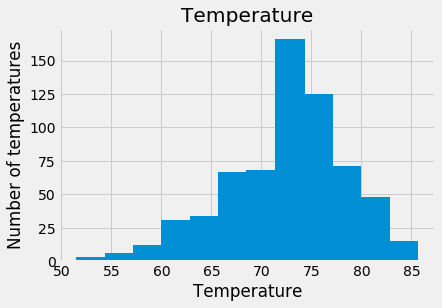

In [57]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
n_bins = 12
# fig, ax = plt.subplots(1, 1, tight_layout=True)
x_axis3 = np.arange(0,646)
plt.bar(tempbins,group_count.temp, width = 3)
plt.title("Temperature")
plt.xlabel("Temperature")
plt.ylabel("Number of temperatures")
# plt.savefig("rainfall.png")
# Show the Figure
plt.show()

![precipitation](Images/station-histogram.png)

# After this point it seems like this is no longer in the gitlab instructions, so I'm just going to ignore it.

In [12]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-01-28', '2012-04-05'))

[(56.0, 69.52115384615385, 79.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


62.0 68.36585365853658 74.0


<IPython.core.display.Javascript object>


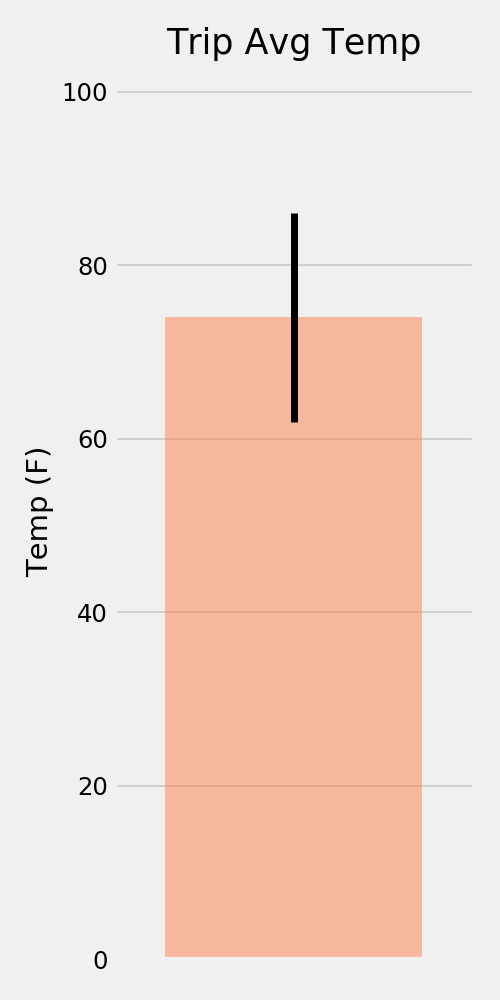

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


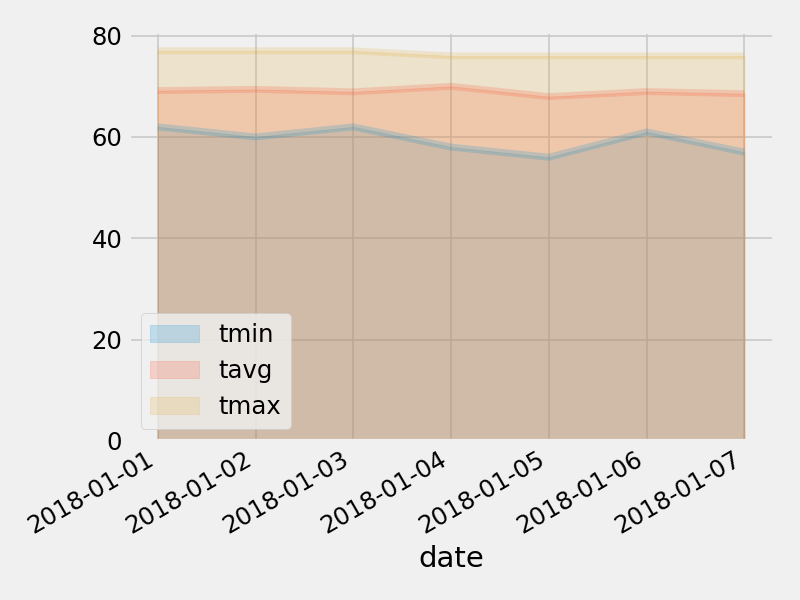

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
